In [6]:
import numpy as np
from pandas import read_csv, DataFrame
from keras import models, layers, initializers
import keras.metrics as km
import keras.backend as kb
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
#import keras2onnx
from sklearn.metrics import roc_curve, auc
from keras.utils import normalize
from scipy import interp
from scipy.stats import boxcox
from itertools import cycle

In [24]:
#Global variables
PREDS_NUM = ["match_balls", "inn_balls", "team_score", "team_lead", "bat_score", "bat_balls", "bat_avg", "career_bat_balls", "bat_sr", "bowl_balls", "bowl_runs", "career_bowl_balls", "bowl_avg", "bowl_sr", "seam_factor", "spin_factor"]
PREDS_CAT = [""]


# Classification metrics
METRICS = [
      km.TruePositives(name='tp'),
      km.FalsePositives(name='fp'),
      km.TrueNegatives(name='tn'),
      km.FalseNegatives(name='fn'), 
      km.BinaryAccuracy(name='accuracy'),
      km.Precision(name='precision'),
      km.Recall(name='recall'),
      km.AUC(name='auc'),
]

def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
#        if metric == 'loss':
#          plt.ylim([0, plt.ylim()[1]])
#        elif metric == 'auc':
#          plt.ylim([0.8,1])
#        else:
#          plt.ylim([0,1])

        plt.legend()

def plot_roc(name, labels, predictions, **kwargs):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(0, roc_auc))
    plt.title(name)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()
    
    return roc_auc



# Pre-processing
This is informed from EDA performed in R

In [38]:
def standardise(x, means = None, sds = None):
    try:
        if means == None:
            means = x.mean(axis = 0)
        if sds == None:
            sds = np.std(x, axis = 0)
    except ValueError:
        pass
        
    x = x - np.array([means]*x.shape[0])
    x = np.divide(x, [sds]*x.shape[0])
    
    return x, means, sds
    

def preprocess(x, ball_col = 1):

    
    return x, DataFrame(data = {'Predictor': PREDS_NUM, 'Transformation': trans, 'Parameters': opt_params})
  
    
def split_new_ball(x, col = 1):
    ball_num, ball_age = np.divmod(x[:,col], 480)
    
    #if np.any(ball_num3): raise ValueError()
    
    ball_num_ind = np.zeros((x.shape[0], 3))
    for i,num in enumerate(ball_num):
        # TODO: vectorise this
        ball_num_ind[i,int(num)-1] = 1
    for i in range(3):
        x = np.insert(x, col + i + 1, ball_num_ind[:,i], axis = 1)
        
    x[:,col] = ball_age
    
    return x
    

# Predicting Wicket

## Load data

In [40]:
# Load data
train_pred = read_csv("data/is_wkt_train_preds.csv")
train_out = read_csv("data/is_wkt_train_labs.csv")
test_pred = read_csv("data/is_wkt_test_preds.csv")
test_out = read_csv("data/is_wkt_test_labs.csv")

# Preprocess
train_x, means, sds = standardise(split_new_ball(train_pred.to_numpy()))
test_x, _, _ = standardise(split_new_ball(test_pred.to_numpy()), means, sds)
train_y = (train_out.to_numpy())[:,1]
test_y = (test_out.to_numpy())[:,1]

# Validation set
val_prop = int(np.ceil(train_x.shape[0]/10))
x_val = train_x[:val_prop]
partial_x_train = train_x[val_prop:]
y_val = train_y[:val_prop]
partial_y_train = train_y[val_prop:]

In [224]:
trans

,Predictor,Transformation,Parameters
0,match_balls,,NaN
1,inn_balls,,NaN
2,team_score,,NaN
3,team_lead,,NaN
4,bat_score,,NaN
5,bat_balls,,NaN
6,bat_avg,Box-Cox,0.576350
7,career_bat_balls,,NaN
8,bat_sr,Box-Cox,0.625389
9,bowl_balls,,NaN


In [225]:
# Data dimensions
print("Training set:", train_x.shape)
print("Training set:", test_x.shape)

print("\nObservations under each label")
print(DataFrame({'Label': ['no', 'W'], 
                 'Training': [train_y.shape[0] - np.sum(train_y), np.sum(train_y)],
                 'Testing': [test_y.shape[0] - np.sum(test_y), np.sum(test_y)]}))

Training set: (455955, 78)
Training set: (151985, 78)

Observations under each label
  Label  Training  Testing
0    no    448563   149621
1     W      7392     2364


## Model Testing

### Network Topology

In [31]:
EPOCHS = 12
BATCH_SIZE =2048


def make_model_wide(input_dim, metrics = METRICS, output_bias = None):
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
        
    model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid',
                     bias_initializer=output_bias)
    ])

    model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=metrics)

    return model

def make_model_deep(input_dim, metrics = METRICS, output_bias = None):
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
        
    model = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(input_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid',
                     bias_initializer=output_bias)
    ])

    model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=metrics)

    return model


In [32]:
def make_model_8deep(input_dim, metrics = METRICS, output_bias = None):
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
        
    model = models.Sequential([
    layers.Dense(8, activation='relu', input_shape=(input_dim,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(8, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid',
                     bias_initializer=output_bias)
    ])

    model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=metrics)

    return model

def make_model_deep8(input_dim, metrics = METRICS, output_bias = None):
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
        
    model = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(input_dim,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid',
                     bias_initializer=output_bias)
    ])

    model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=metrics)

    return model

def make_model_deep64(input_dim, metrics = METRICS, output_bias = None):
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
        
    model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid',
                     bias_initializer=output_bias)
    ])

    model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=metrics)

    return model

def make_model_deep128(input_dim, metrics = METRICS, output_bias = None):
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
        
    model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid',
                     bias_initializer=output_bias)
    ])

    model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=metrics)

    return model

def make_model_deep512(input_dim, metrics = METRICS, output_bias = None):
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
        
    model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(input_dim,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid',
                     bias_initializer=output_bias)
    ])

    model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=metrics)

    return model

In [33]:
def test_model(build_model, train_x, train_y, test_x, test_y, val_x, val_y, epochs = EPOCHS, batch_size = BATCH_SIZE, plots = True, **kwargs):
    
    def perf_sum(x,y, name):
        pred = model.predict(x)
        mets = model.evaluate(x,y,verbose = 0)
        
        cauc = plot_roc(name, y, pred)
        print("Accuracy:", mets[5])
        print("Precision:", mets[6])
        print("Recall:", mets[7])
        print("AUC:", cauc)
        print("Maximum wkt prob:", max(pred))  
    
    # Compile model
    print('Compiling model...')
    neg, pos = np.bincount(partial_y_train)
    initial_bias = np.log([pos/neg])
    model = build_model(train_x.shape[1], output_bias = initial_bias)
    
    # Scaled initial weights
    total = neg + pos
    weight_for_0 = (1 / neg)*(total)/2.0 
    weight_for_1 = (1 / pos)*(total)/2.0
    class_weight = {0: weight_for_0, 1: weight_for_1}
    print('Compilation complete\n')
    
    # Train model
    print('Training model...')
    history = model.fit(train_x, train_y, epochs = epochs, batch_size = batch_size, validation_data=(val_x, val_y), class_weight=class_weight, verbose = 0, **kwargs)
    print('Training complete\n')
    
    

    
    # Print a performance report
    print("============== Model Report ==============\n")
    print(model.summary())
    
    if (plots):
        print("\n")
        print("============== Training History Plots ==============\n")

        plot_metrics(history)
        plt.show()
    
    print("\n")
    print("============== Performance Metrics ==============\n")
    print("==== Training Set ====")
    perf_sum(train_x, train_y, "Training Set")
    print("\n==== Validation Set ====")
    perf_sum(val_x, val_y, "Validation Set")
    print("\n==== Testing Set ====")
    perf_sum(test_x, test_y, "Testing Set")
    
    
    # Return model
    return model, history
    
    

Compiling model...
Compilation complete

Training model...
Training complete

============== Model Report ==============

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 512)               40448     
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 513       
Total params: 40,961
Trainable params: 40,961
Non-trainable params: 0
_________________________________________________________________
None


============== Training History Plots ==============



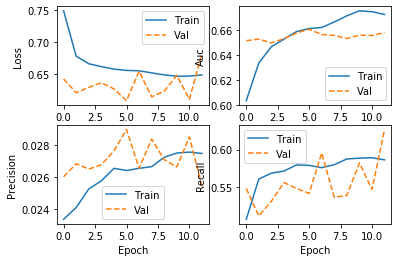



============== Performance Metrics ==============

==== Training Set ====


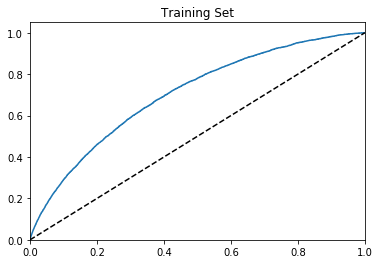

Accuracy: 0.5993532538414001
Precision: 0.027689967304468155
Recall: 0.6974815130233765
AUC: 0.7037908920799038
Maximum wkt prob: [0.99971867]

==== Validation Set ====


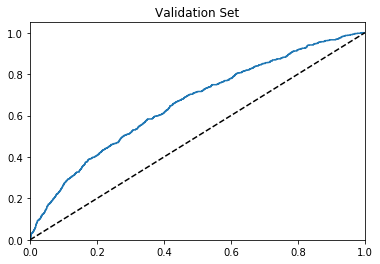

Accuracy: 0.5928809642791748
Precision: 0.025431862100958824
Recall: 0.6268068552017212
AUC: 0.6577248861242866
Maximum wkt prob: [0.9995294]

==== Testing Set ====


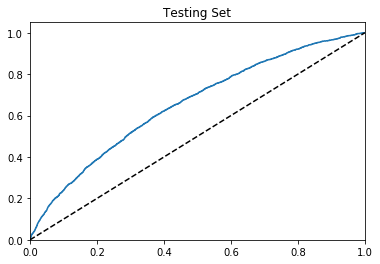

Accuracy: 0.5958877801895142
Precision: 0.023895902559161186
Recall: 0.6269035339355469
AUC: 0.653887460218012
Maximum wkt prob: [0.95598054]


In [238]:
model_wide, history_wide = test_model(make_model_wide, partial_x_train, partial_y_train, test_x, test_y, x_val, y_val)

Compiling model...
Compilation complete

Training model...
Training complete

============== Model Report ==============

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 16)                1264      
_________________________________________________________________
dense_78 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_79 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_80 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 17        
Total params: 2,097
Trainable params: 2,097
Non-trainable params: 0
_____________________________________________________________

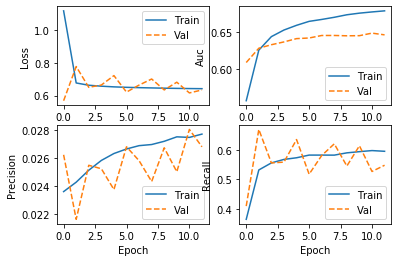



============== Performance Metrics ==============

==== Training Set ====


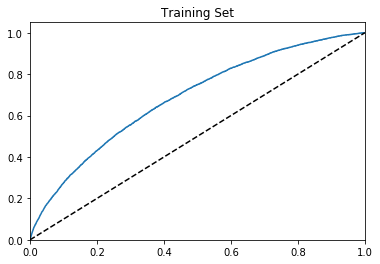

Accuracy: 0.6643694639205933
Precision: 0.028343023732304573
Recall: 0.5940280556678772
AUC: 0.6845567251685114
Maximum wkt prob: [0.99585783]

==== Validation Set ====


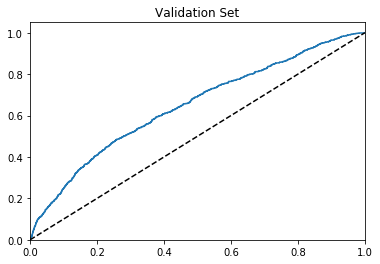

Accuracy: 0.660321056842804
Precision: 0.026797764003276825
Recall: 0.5479632019996643
AUC: 0.6459202211291014
Maximum wkt prob: [0.99111915]

==== Testing Set ====


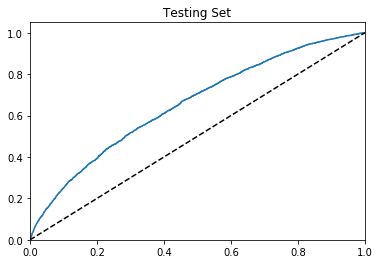

Accuracy: 0.6620784997940063
Precision: 0.025196239352226257
Recall: 0.5499153733253479
AUC: 0.6553706550214053
Maximum wkt prob: [0.94392633]


In [239]:
model_deep, history_deep = test_model(make_model_deep, partial_x_train, partial_y_train, test_x, test_y, x_val, y_val)


#history_wide = model_wide.fit(partial_x_train,
#partial_y_train,
#epochs=EPOCHS,
#batch_size=BATCH_SIZE,
#validation_data=(x_val, y_val),
                           #class_weight=class_weight, 
                   #callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)])

Compiling model...
Compilation complete

Training model...
Epoch 00010: early stopping
Training complete

============== Model Report ==============

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 8)                 632       
_________________________________________________________________
dense_103 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_104 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_105 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_106 (Dense)            (None, 1)                 9         
Total params: 857
Trainable params: 857
Non-trainable params: 0
_____________________________________

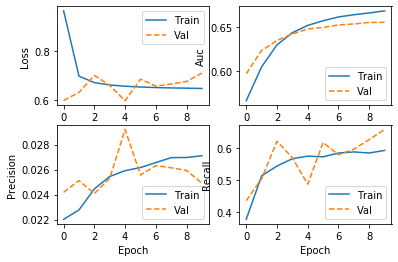



============== Performance Metrics ==============

==== Training Set ====


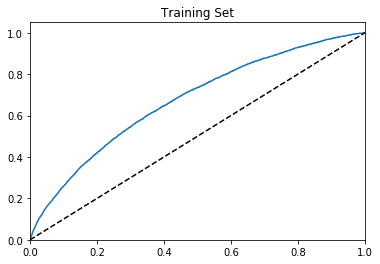

Accuracy: 0.5681318044662476
Precision: 0.02509409561753273
Recall: 0.6796863079071045
AUC: 0.673411936776987
Maximum wkt prob: [0.9912629]

==== Validation Set ====


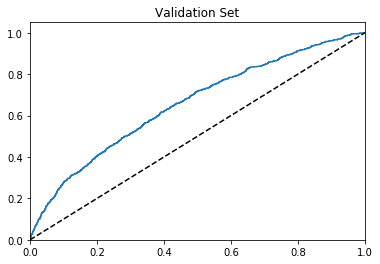

Accuracy: 0.5649837851524353
Precision: 0.02490784041583538
Recall: 0.6570302248001099
AUC: 0.6553831416024328
Maximum wkt prob: [0.99193454]

==== Testing Set ====


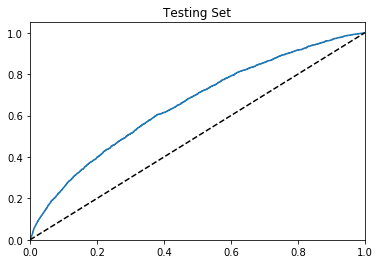

Accuracy: 0.5662071704864502
Precision: 0.02283509448170662
Recall: 0.643401026725769
AUC: 0.6550860244051944
Maximum wkt prob: [0.94341254]


In [247]:
_,_ = test_model(make_model_8deep, partial_x_train, partial_y_train, test_x, test_y, x_val, y_val, callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)])

Compiling model...
Compilation complete

Training model...
Training complete

============== Model Report ==============

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 64)                5056      
_________________________________________________________________
dense_98 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_99 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_100 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 65        
Total params: 17,601
Trainable params: 17,601
Non-trainable params: 0
___________________________________________________________

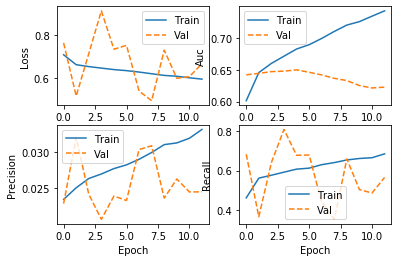



============== Performance Metrics ==============

==== Training Set ====


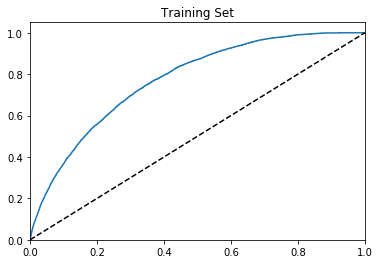

Accuracy: 0.6250502467155457
Precision: 0.03265596181154251
Recall: 0.7757502794265747
AUC: 0.7727004509122617
Maximum wkt prob: [0.9943693]

==== Validation Set ====


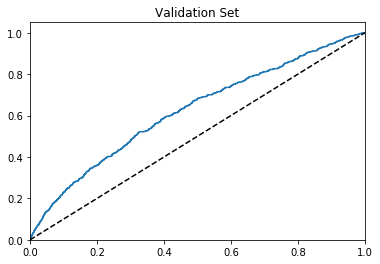

Accuracy: 0.6172909736633301
Precision: 0.024502821266651154
Recall: 0.5650460124015808
AUC: 0.6226752142876926
Maximum wkt prob: [0.9775456]

==== Testing Set ====


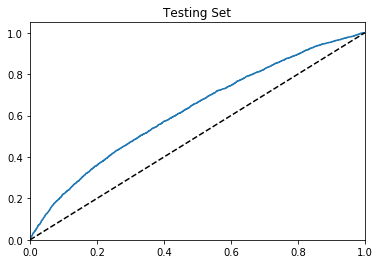

Accuracy: 0.6175017356872559
Precision: 0.022369908168911934
Recall: 0.5524534583091736
AUC: 0.6235958967435498
Maximum wkt prob: [0.987782]


In [245]:
_,_ = test_model(make_model_deep64, partial_x_train, partial_y_train, test_x, test_y, x_val, y_val)

Compiling model...
Compilation complete

Training model...
Training complete

============== Model Report ==============

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 128)               10112     
_________________________________________________________________
dense_88 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_89 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_90 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 129       
Total params: 59,777
Trainable params: 59,777
Non-trainable params: 0
___________________________________________________________

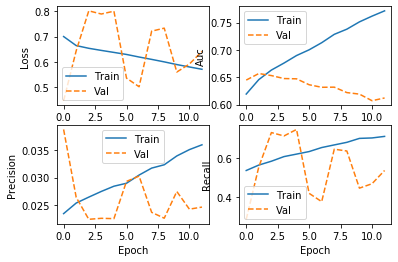



============== Performance Metrics ==============

==== Training Set ====


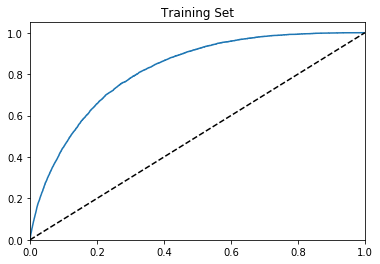

Accuracy: 0.6491608619689941
Precision: 0.03712715953588486
Recall: 0.8306439518928528
AUC: 0.8177463610407225
Maximum wkt prob: [0.99920046]

==== Validation Set ====


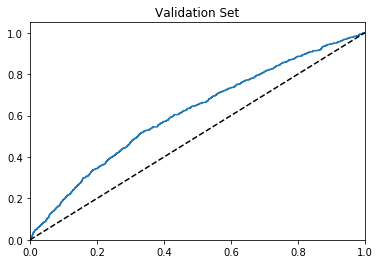

Accuracy: 0.6385428309440613
Precision: 0.02467343956232071
Recall: 0.5361366868019104
AUC: 0.6121555647096736
Maximum wkt prob: [0.9993516]

==== Testing Set ====


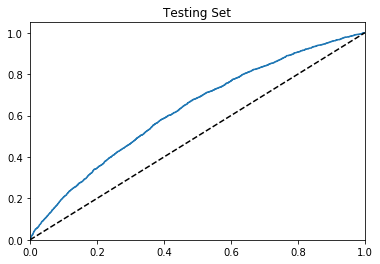

Accuracy: 0.6398262977600098
Precision: 0.023056330159306526
Recall: 0.5355330109596252
AUC: 0.6277828222964847
Maximum wkt prob: [0.9864749]


In [243]:
_,_ = test_model(make_model_deep128, partial_x_train, partial_y_train, test_x, test_y, x_val, y_val)

Compiling model...
Compilation complete

Training model...
Training complete

============== Model Report ==============

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 512)               40448     
_________________________________________________________________
dense_93 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_94 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_95 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_96 (Dense)             (None, 1)                 513       
Total params: 828,929
Trainable params: 828,929
Non-trainable params: 0
_________________________________________________________

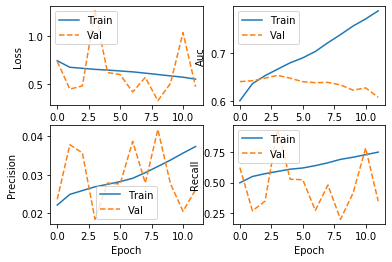



============== Performance Metrics ==============

==== Training Set ====


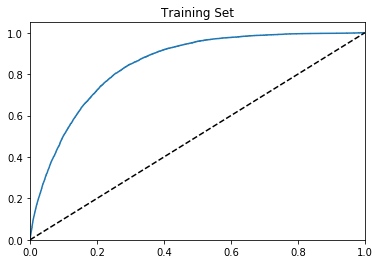

Accuracy: 0.7887094020843506
Precision: 0.054728858172893524
Recall: 0.7421203255653381
AUC: 0.8481153560145039
Maximum wkt prob: [0.9996819]

==== Validation Set ====


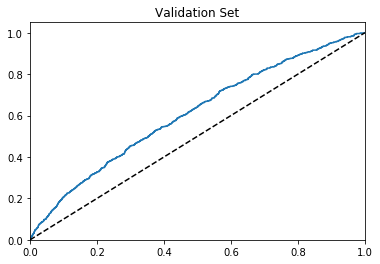

Accuracy: 0.7721291184425354
Precision: 0.026085244491696358
Recall: 0.34822601079940796
AUC: 0.6082614644703233
Maximum wkt prob: [0.99939525]

==== Testing Set ====


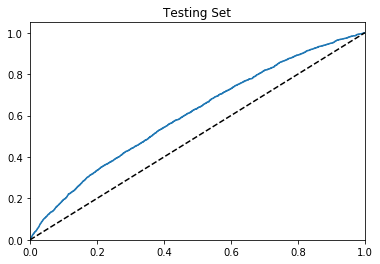

Accuracy: 0.7766753435134888
Precision: 0.025199975818395615
Recall: 0.3544839322566986
AUC: 0.6053978704297767
Maximum wkt prob: [0.9954618]


In [244]:
_,_ = test_model(make_model_deep512, partial_x_train, partial_y_train, test_x, test_y, x_val, y_val)

# Final Fit

In [66]:
def make_model_final(input_dim, metrics = METRICS, output_bias = None):
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
        
    model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid',
                     bias_initializer=output_bias)
    ])

    model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=metrics)

    return model

Compiling model...
Compilation complete

Training model...
Epoch 00013: early stopping
Training complete

============== Model Report ==============

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 32)                2624      
_________________________________________________________________
dense_41 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_42 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_43 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_44 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_45 (Dense)             (None, 

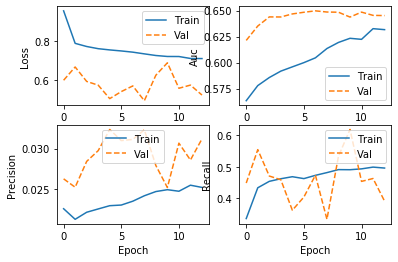



============== Performance Metrics ==============

==== Training Set ====


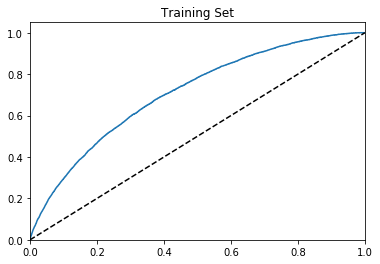

Accuracy: 0.7933589816093445
Precision: 0.03693128004670143
Recall: 0.47006484866142273
AUC: 0.708840280841642
Maximum wkt prob: [0.9971509]

==== Validation Set ====


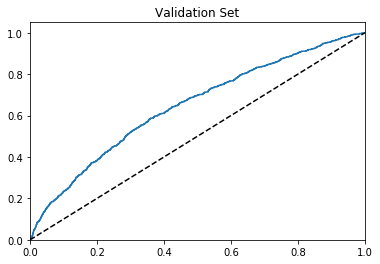

Accuracy: 0.7874155640602112
Precision: 0.031177829951047897
Recall: 0.3902759552001953
AUC: 0.6452584428786701
Maximum wkt prob: [0.99555355]

==== Testing Set ====


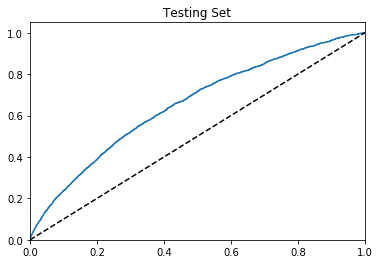

Accuracy: 0.7898871302604675
Precision: 0.02973918616771698
Recall: 0.3955160677433014
AUC: 0.6536982780440022
Maximum wkt prob: [0.9553039]


In [67]:
model, history = test_model(make_model_final, partial_x_train, partial_y_train, test_x, test_y, x_val, y_val, batch_size = 5012, epochs = 50, callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)])

Compiling model...
Compilation complete

Training model...
Training complete

============== Model Report ==============

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                2624      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      


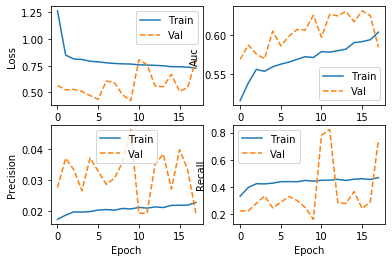



============== Performance Metrics ==============

==== Training Set ====


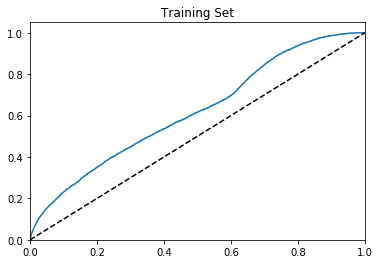

Accuracy: 0.36144450306892395
Precision: 0.019186891615390778
Recall: 0.7685115337371826
AUC: 0.6192575824442721
Maximum wkt prob: [0.94587654]

==== Validation Set ====


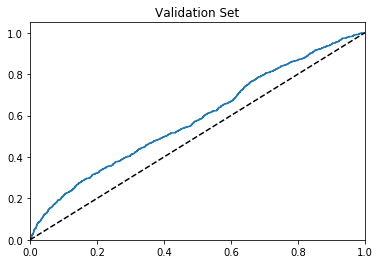

Accuracy: 0.35711467266082764
Precision: 0.019197089597582817
Recall: 0.7490144371986389
AUC: 0.5841430404694568
Maximum wkt prob: [0.9457428]

==== Testing Set ====


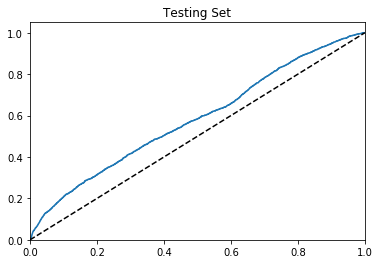

Accuracy: 0.35723263025283813
Precision: 0.01724853925406933
Recall: 0.720389187335968
AUC: 0.5825240451590653
Maximum wkt prob: [0.9434208]


In [39]:
# Try with transformed innings balls
model, history = test_model(make_model_final, split_new_ball(partial_x_train), partial_y_train, split_new_ball(test_x), test_y, split_new_ball(x_val), y_val, batch_size = 8000, epochs = 18)

## Manual Assessment

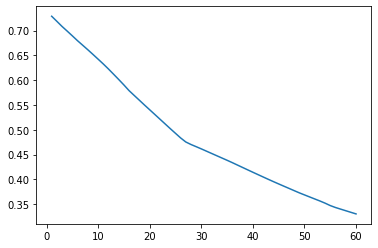

In [53]:
##### Wicket probability for batting average
bat_avgs = list(range(1,61))

bat_avg_data = np.array([test_pred.to_numpy()[1,:],]*len(bat_avgs))
bat_avg_data[:,6] = bat_avgs



bat_avg_data, _, _ = standardise(split_new_ball(bat_avg_data), means, sds)
ba_exp = model.predict(bat_avg_data)
plt.plot(bat_avgs, ba_exp)

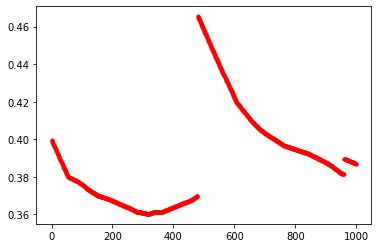

In [60]:
##### Wicket probability for innings balls
inn_balls = list(range(1000))

inn_balls_data = np.array([test_pred.to_numpy()[10,:],]*len(inn_balls))
inn_balls_data[:,1] = inn_balls

inn_balls_data,_,_ = standardise(split_new_ball(inn_balls_data), means, sds)
ib_exp = model.predict(inn_balls_data)
plt.plot(inn_balls, ib_exp, 'r.')

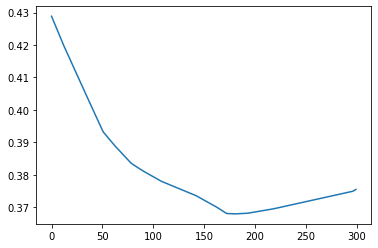

In [50]:
##### Wicket probability for seam factor
bat_balls = list(range(300))

bat_balls_data = np.array([test_pred.to_numpy()[0,:],]*len(bat_balls))
bat_balls_data[:,5] = bat_balls

bat_balls_data,_,_ = standardise(split_new_ball(bat_balls_data), means, sds)
bb_exp = model.predict(bat_balls_data)
plt.plot(bat_balls, bb_exp)

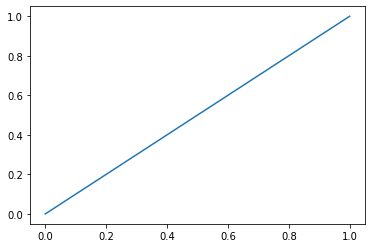

In [49]:
##### Wicket probability for batter balls
seam = list(np.linspace(0,1,100))

seam_data = np.array([test_pred.to_numpy()[0,:],]*len(seam))
seam_data[:,14] = seam

seam_data,_,_ = standardise(split_new_ball(seam_data), means, sds)
seam_exp = model.predict(seam_data)
plt.plot(seam, seam)

# Ignore, for reference

In [ ]:
# Predictions on test set
test_pred = model_out.predict(test_x_out)

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes_out):
    fpr[i], tpr[i], _ = roc_curve(test_y_out[:, i], test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



# Plot all ROC curves

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes_out), colors):
    #plt.subplot(11,2,i + 1)
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    plt.title(codes_out[i])
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()
    print(codes_out[i], roc_auc[i])
    